# 2. Development & Optimisation 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [56]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import random

from petl import fromcsv, look, fieldnames, values, head, tail

import seaborn as sns

from mpl_toolkits.basemap import Basemap

import os

from datetime import datetime

import datetime

from dateutil.relativedelta import relativedelta

import math

from pygeocoder import Geocoder

import time


In [3]:
dataset = pd.read_csv('cleaned_yellow_tripdata_2015-06.csv', skipinitialspace=True)
print "Number of trips registered: ", len(dataset)

Number of trips registered:  11995646


In [4]:
new_dataset = dataset.iloc[np.random.permutation(len(dataset))]

In [160]:
work_data = new_dataset[:1000]
pick_dt ,drop_dt = pd.DatetimeIndex(work_data['tpep_pickup_datetime']), pd.DatetimeIndex(work_data['tpep_dropoff_datetime'])

Get trip time 

In [264]:
FMT = '%Y-%m-%d %H:%M:%S'
str_drop = [datetime.datetime.strptime(str(drop_trip_time),FMT) for drop_trip_time in drop_dt] 
str_pick = [datetime.datetime.strptime(str(pick_trip_time),FMT) for pick_trip_time in pick_dt]
triptimes_temp = [relativedelta(str_drop[i], str_pick[i]) for i in range(0,len(str_pick))]
work_data ['trip_time'] = [triptimes_temp[i].minutes + triptimes_temp[i].seconds / 60. for i in range(0,len(work_data))]


#work_data.trip_time.values[0] way to obtain values of time

In [162]:
work_data = work_data.drop(['Unnamed: 0','VendorID','store_and_fwd_flag'], axis=1)
work_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
2584803,2015-06-09 21:59:42,2015-06-09 22:12:00,1,5.20,-73.788864,40.647358,1,-73.848785,40.666889,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,12.300000
5235488,2015-06-12 12:32:30,2015-06-12 12:47:56,5,0.78,-73.993469,40.743240,1,-73.988548,40.748840,1,10.0,0.0,0.5,0.54,0.0,0.3,11.34,15.433333
4077592,2015-06-11 18:50:16,2015-06-11 18:59:28,2,1.61,-74.003922,40.715836,1,-74.001472,40.735161,2,8.5,1.0,0.5,0.00,0.0,0.3,10.30,9.200000
10030007,2015-06-26 21:04:08,2015-06-26 21:14:29,1,1.90,-73.982330,40.768341,1,-73.985229,40.746868,1,9.5,0.5,0.5,2.15,0.0,0.3,12.95,10.350000
7227525,2015-06-21 17:38:43,2015-06-21 18:03:37,1,2.00,-73.990974,40.749706,1,-73.980721,40.764660,2,16.0,0.0,0.5,0.00,0.0,0.3,16.80,24.900000


In [163]:
work_data['day_ofweek'] = pick_dt.dayofweek
work_data['hour'] = pick_dt.hour

In [164]:
work_data['dif_tip'] = work_data.total_amount[:] *0.2 - work_data.tip_amount[:]

Text(0.5,1,u'Variance Distribution Paid Tip vs 20% Tip Estimation ')

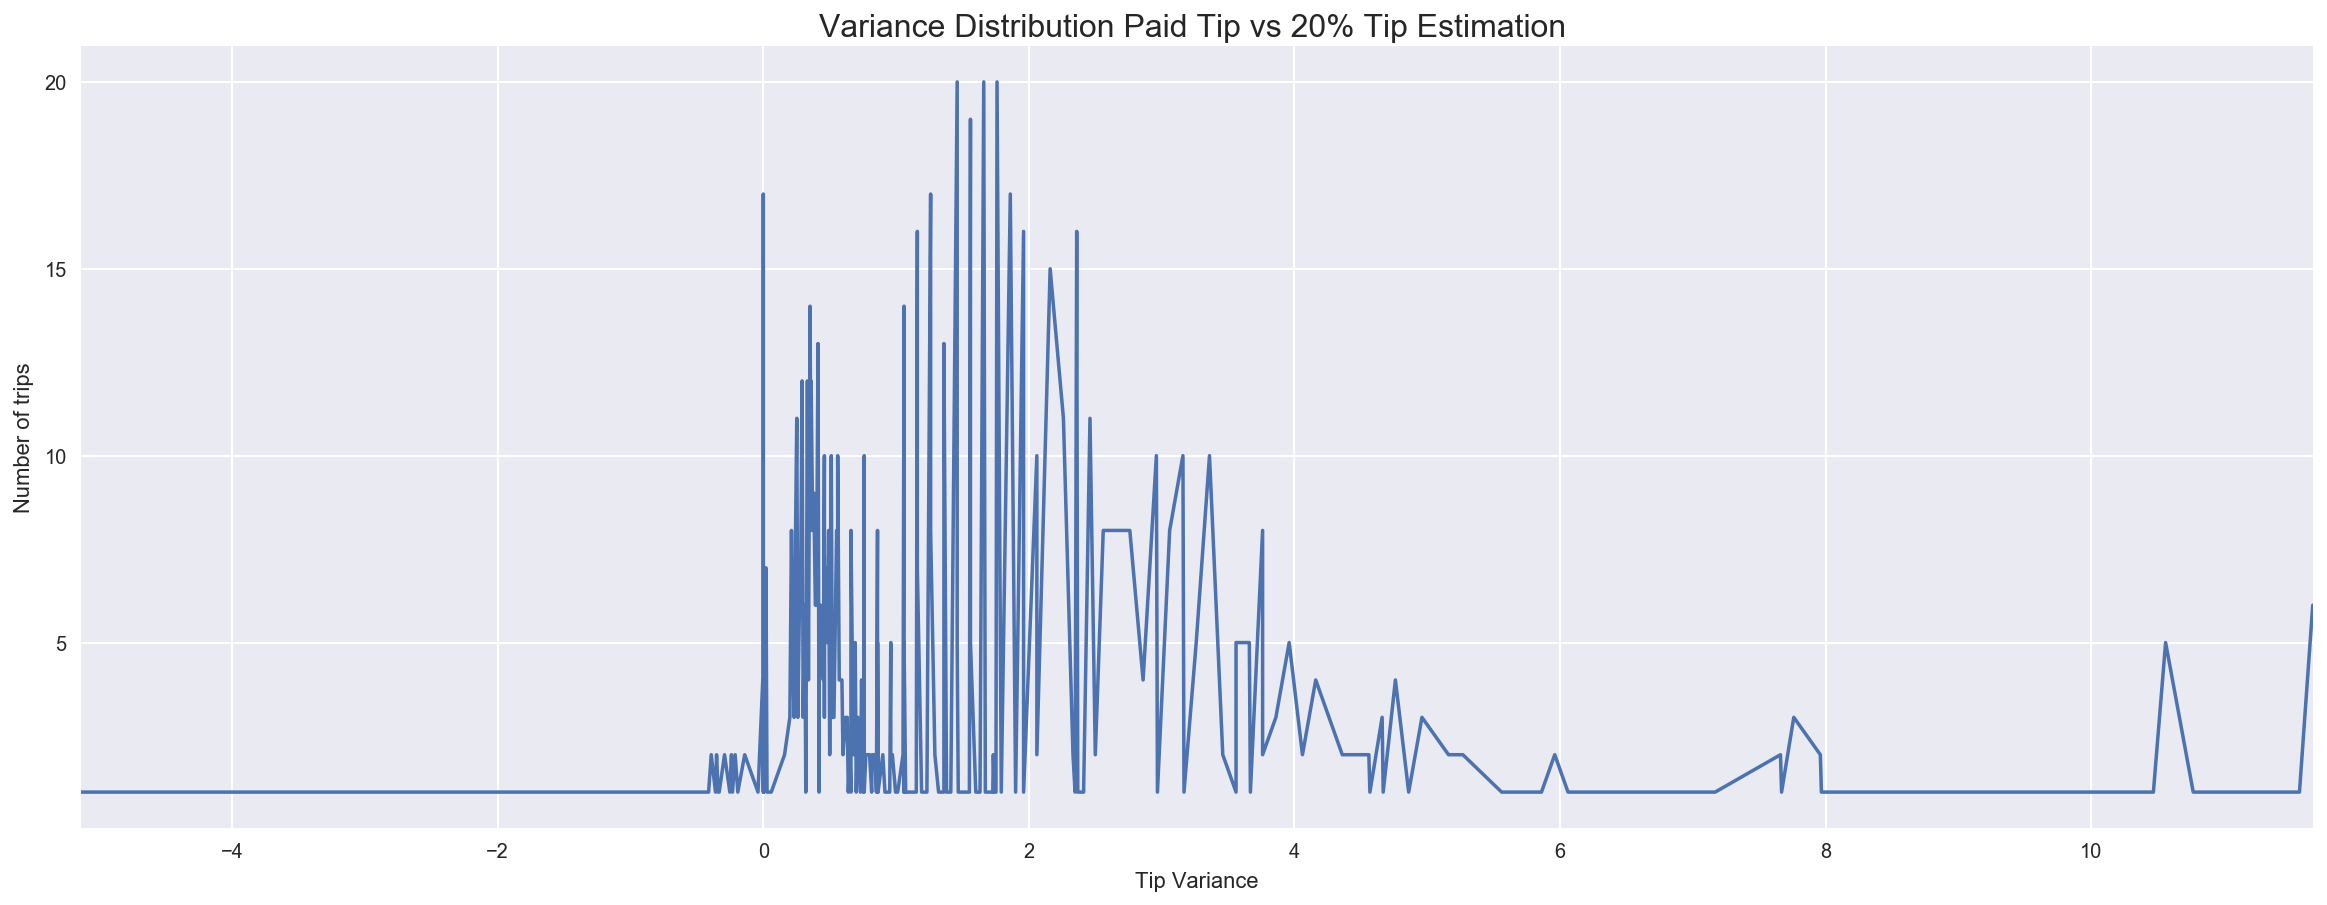

In [165]:
work_data.groupby(work_data.dif_tip.values).size().plot(figsize=(20,7))

plt.ylabel('Number of trips')
plt.xlabel('Tip Variance')
plt.title('Variance Distribution Paid Tip vs 20% Tip Estimation ', fontsize = 16)



In [166]:
vel = work_data.trip_distance.values / work_data.trip_time.values

In [72]:
#Latitude & Longitude Positions from NY neighborhoods obtained from http://www.guiaturismonewyork.com/
#midtown_lat, midtown_long = 40.754931, -73.984019 

def get_geocoder_noquery_limit(latitude_values,longitude_values):
    
    geocodes = []
    
    for i in range (0,len(latitude_values)):
        geocode = Geocoder.reverse_geocode(latitude_values[i], longitude_values[i])
        geocodes.append(geocode)
        #Include some delay on odd numbers to avoid GeocoderError: Error OVER_QUERY_LIMIT
        time.sleep(1)
    return geocodes


In [77]:
pick_geocode = get_geocoder_noquery_limit(work_data['pickup_latitude'].values,work_data['pickup_longitude'].values)
#pick_geocode = [Geocoder.reverse_geocode(work_data['pickup_latitude'].values[i], work_data['pickup_longitude'].values[i]) for i in range(0,len(work_data))]

In [85]:
drop_geocode = get_geocoder_noquery_limit(work_data['dropoff_latitude'].values,work_data['dropoff_longitude'].values)

In [546]:
work_data['pick_zone'] = pick_geocode[:].postal_code
work_data['drop_zone'] = drop_geocode[:].postal_code

In [262]:
Geocoder.reverse_geocode(work_data['dropoff_latitude'].values[999], work_data['dropoff_longitude'].values[999])

GeocoderError: Error OVER_QUERY_LIMIT
Query: https://maps.google.com/maps/api/geocode/json?region=&latlng=40.763496%2C-73.965630&sensor=false&bounds=&language=

Splitting dataset into training and test data

In [167]:
work_data = work_data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1)

In [168]:
training_size = 0.7
n_data = int(round(len(work_data)*training_size))
training_data = work_data[0:n_data]
testing_data = work_data[n_data:]

In [263]:
training_data.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,day_ofweek,hour,dif_tip
2584803,1,5.20,-73.788864,40.647358,1,-73.848785,40.666889,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,12.300000,1,21,3.560
5235488,5,0.78,-73.993469,40.743240,1,-73.988548,40.748840,1,10.0,0.0,0.5,0.54,0.0,0.3,11.34,15.433333,4,12,1.728
4077592,2,1.61,-74.003922,40.715836,1,-74.001472,40.735161,2,8.5,1.0,0.5,0.00,0.0,0.3,10.30,9.200000,3,18,2.060
10030007,1,1.90,-73.982330,40.768341,1,-73.985229,40.746868,1,9.5,0.5,0.5,2.15,0.0,0.3,12.95,10.350000,4,21,0.440
7227525,1,2.00,-73.990974,40.749706,1,-73.980721,40.764660,2,16.0,0.0,0.5,0.00,0.0,0.3,16.80,24.900000,6,17,3.360


# Labeling Tip Amount

In [239]:
#tip_labels = ['[0-5)', '[5-10)', '[10-15)', '[15-20)', '[20-25)', '[25+]']
tip_labels = range(1, 7)
tip_ranges_by_label = [[0.0, 4.99], [5.0, 9.99], [10.0, 14.99], [15.0, 19.99], [20.0, 24.99], [25.0, 30.0]]

In [240]:
new_data = work_data

In [252]:
tips_label_list = []
tips = np.array(new_data.tip_amount.values).tolist()

for tip in tips:
    for i, tip_label in enumerate(tip_labels):
        tip_mask = ((tip >= tip_ranges_by_label[i][0]) & (tip < tip_ranges_by_label[i][1]))
        if tip_mask is True:
            tips_label_list.append(tip_labels[i])
            tip_mask = None
            
new_data['tip_label'] = tips_label_list

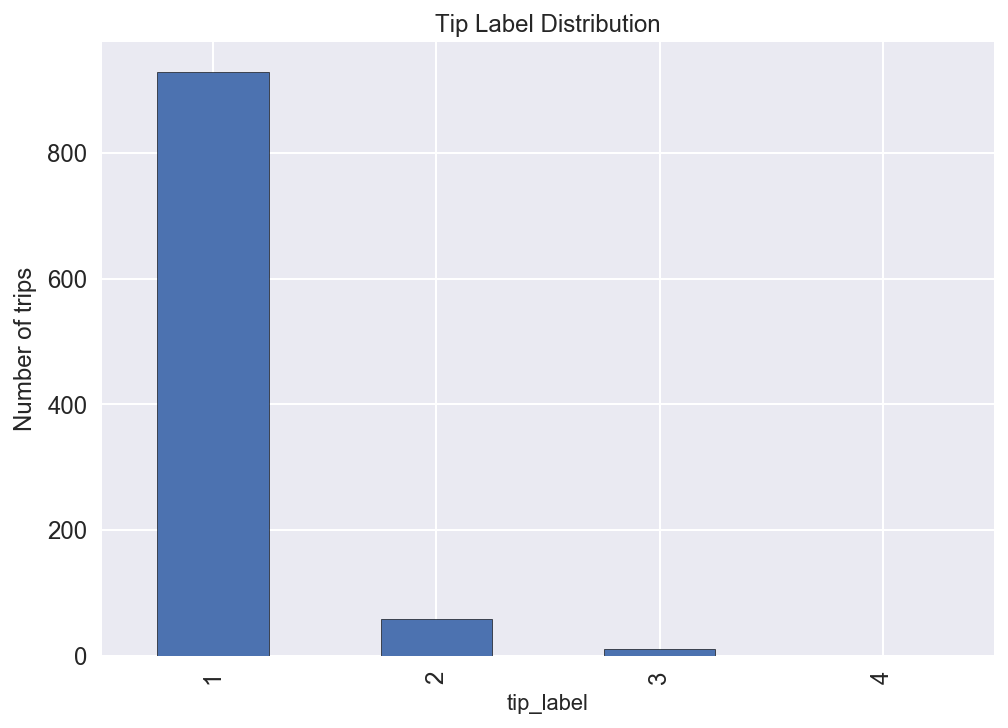

In [261]:
new_data.groupby('tip_label').size().plot(kind='bar')

plt.title('Tip Label Distribution')
plt.ylabel('Number of trips', fontsize=12)
plt.tick_params(labelsize=12)

In [207]:
type(k.tolist())

list

In [210]:
k = np.array(k).tolist()

In [223]:
new_data

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,day_ofweek,hour,dif_tip,tip_label,False
2584803,1,5.20,-73.788864,40.647358,1,-73.848785,40.666889,2,16.5,0.5,...,0.00,0.00,0.3,17.80,12.300000,1,21,3.560,,[25+]
5235488,5,0.78,-73.993469,40.743240,1,-73.988548,40.748840,1,10.0,0.0,...,0.54,0.00,0.3,11.34,15.433333,4,12,1.728,,[25+]
4077592,2,1.61,-74.003922,40.715836,1,-74.001472,40.735161,2,8.5,1.0,...,0.00,0.00,0.3,10.30,9.200000,3,18,2.060,,[25+]
10030007,1,1.90,-73.982330,40.768341,1,-73.985229,40.746868,1,9.5,0.5,...,2.15,0.00,0.3,12.95,10.350000,4,21,0.440,,[25+]
7227525,1,2.00,-73.990974,40.749706,1,-73.980721,40.764660,2,16.0,0.0,...,0.00,0.00,0.3,16.80,24.900000,6,17,3.360,,[25+]
11220533,1,1.40,-73.899971,40.745964,1,-73.877365,40.752552,2,7.5,0.5,...,0.00,0.00,0.3,8.80,7.766667,0,0,1.760,,[25+]
6065405,1,1.58,-73.969345,40.798210,1,-73.956100,40.784828,1,8.5,1.0,...,2.00,0.00,0.3,12.30,8.933333,4,18,0.460,,[25+]
9117590,1,3.17,-74.005142,40.718456,1,-73.978416,40.751133,2,18.0,0.0,...,0.00,0.00,0.3,18.80,27.516667,3,9,3.760,,[25+]
7548545,6,0.70,-73.959000,40.772041,1,-73.959869,40.779411,2,5.0,0.0,...,0.00,0.00,0.3,5.80,5.050000,0,12,1.160,,[25+]
1826507,3,0.70,-74.007675,40.712776,1,-74.014626,40.715485,1,6.0,0.0,...,1.35,0.00,0.3,8.15,7.366667,2,13,0.280,,[25+]
